## importing proper libraries

In [1]:
%%capture
!pip install  mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import files
uploaded = files.upload()

Saving AFLW2000-3D.zip to AFLW2000-3D.zip


# Loading the data

This cell about is loading the AFLW2000 dataset, which contains 2000 annotated 3D facial scans of human faces. The dataset is stored in a compressed zip file called "AFLW2000-3D.zip" and is located in the current working directory.

Here's a breakdown of what each line of the code is doing:

import zipfile: This imports the zipfile module, which provides tools for working with compressed zip files in Python.

path = '/content/AFLW2000-3D.zip': This sets the path variable to the file path of the zip file containing the AFLW2000 dataset.

zip_object = zipfile.ZipFile(file = path,mode = 'r'): This creates a ZipFile object that represents the compressed zip file at the specified file path. The mode argument is set to "r" to indicate that the zip file is being opened in read mode.

zip_object.extractall('./'): This extracts all the files in the zip archive to the current working directory, which is specified as './'. The extractall() method is used to extract all files and directories in the archive.

zip_object.close(): This closes the ZipFile object, releasing any resources that it was using

In [3]:
# Loading AFLW2000 Data
import zipfile
path = '/content/AFLW2000-3D.zip'
zip_object = zipfile.ZipFile(file = path,mode = 'r')
zip_object.extractall('./')
zip_object.close()

here we extract just the images using glob , and they are 2000 images

In [4]:
images = sorted(glob.glob("/content/AFLW2000/*.jpg"))
len(images)

2000

here we extract just the matlab files using glob , and they are 2000 matfiles

In [5]:
mat_files = sorted(glob.glob("/content/AFLW2000/*.mat"))
len(mat_files)

2000

# Extracting the  features and labels from the images and Mat files

getting_poses is a function that recieves the mat files and gets the poses of the face which will be our labels

In [6]:
#function to extract single label
def getting_poses(file):
    labels = []
    mat_file = sio.loadmat(file)
    pose_param = mat_file["Pose_Para"][0][:3]
    return pose_param  

This is cell contains a function called getting_data() that takes in two arguments: images and files. The images argument is a list of file paths to images of human faces, and the files argument is a corresponding list of file names for the images.

Here's a breakdown of what each line of the code is doing:

labels = []: This initializes an empty list called labels that will be used to store the pose parameters for each face.

x_1 = []: This initializes an empty list called x_1 that will be used to store the x-coordinates of the face landmarks for each image.

y_1 = []: This initializes an empty list called y_1 that will be used to store the y-coordinates of the face landmarks for each image.

face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True): This creates an instance of the FaceMesh class from the Mediapipe library, which will be used to detect and extract the 468 facial landmarks from each image.

for (image,file) in zip(images,files):: This starts a loop that iterates over each pair of image and file in the images and files lists, respectively.

img = cv2.imread(image): This uses the cv2.imread() function from OpenCV to read in the image at the current iteration.

height,width,_ = img.shape: This retrieves the height and width of the image, which will be used to convert the relative landmark positions to absolute pixel positions.

img_new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB): This converts the image from BGR format (which is the default format used by OpenCV) to RGB format (which is the format expected by Mediapipe).

result = face_mesh.process(img_new): This processes the image using the process() method of the FaceMesh class, which returns a FaceMeshResults object containing information about the detected facial landmarks.

if result.multi_face_landmarks != None:: This checks if there are any faces detected in the image. If there are no faces, the code inside the if block is skipped.

for face in result.multi_face_landmarks:: This starts a loop that iterates over each detected face in the image.

x_list = []: This initializes an empty list called x_list that will be used to store the x-coordinates of the landmarks for the current face.

y_list = []: This initializes an empty list called y_list that will be used to store the y-coordinates of the landmarks for the current face.

for landmark in face.landmark:: This starts a loop that iterates over each of the 468 facial landmarks for the current face.

x = landmark.x: This retrieves the normalized x-coordinate of the current landmark, which ranges from 0 to 1.

y = landmark.y: This retrieves the normalized y-coordinate of the current landmark, which also ranges from 0 to 1.

relative_x = int(x * width): This converts the normalized x-coordinate to an absolute pixel position by multiplying it by the width of the image and rounding it to the nearest integer.

relative_y = int(y * height): This converts the normalized y-coordinate to an absolute pixel position by multiplying it by the height of the image and rounding it to the nearest integer.

x_list.append(relative_x): This adds the absolute x-coordinate of the current

In [7]:
# function to extract features and labels
def getting_data(images,files):
    labels = []
    x_1 = []
    y_1 = []
    face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
    for (image,file) in zip(images,files):
        img = cv2.imread(image)
        height,width,_ = img.shape
        img_new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        result = face_mesh.process(img_new)
        if result.multi_face_landmarks != None:
            for face in result.multi_face_landmarks:
                x_list = []
                y_list = []
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    relative_x = int(x * width)
                    relative_y = int(y * height)
                    x_list.append(relative_x)
                    y_list.append(relative_y)
                x_array = np.array(x_list)
                y_array = np.array(y_list)

                x_1.append(x_array)
                y_1.append(y_array)

                x_arr = np.array(x_1)
                y_arr = np.array(y_1)
                pose_param = getting_poses(file)
                labels.append(pose_param)
    labels = np.array(labels)
    return x_arr,y_arr,labels

here we have 1853 images with right poses and 147 images with wrong poses with , the missed 147 images are due to that mediapipe library could not identifiy the face landmarks ,

and we have 468 ***X*** points and 468 ***Y*** points which represent the landmarks for each face 

finally, we have also 3 labels which are pitch , yaw and roll for each image 

In [8]:
x_array,y_array,labels = getting_data(images,mat_files)
print(x_array.shape)
print(y_array.shape)
print(labels.shape)

(1853, 468)
(1853, 468)
(1853, 3)


# Normalizing the data

The code first computes the difference between the x-coordinates and y-coordinates of each point and the x-coordinate and y-coordinate of the point at index 195, respectively. This centers the data around point 195.

Next, it computes the distance between point 10 and point 152 and normalizes the x-coordinates and y-coordinates by this distance. This step is performed to ensure that all points are on the same scale.

Finally, it concatenates the normalized x-coordinates and y-coordinates to form the complete features matrix.

In [9]:
# the data should be normalized around the center of the face
# center = 195
# Top of Head = 10
# Bottom of Head = 152
x_center = x_array - x_array[:,195].reshape(-1,1)
y_center = y_array - y_array[:,195].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 152
x_152 = x_array[:,152]
x_10 = x_array[:,10]
y_152 = y_array[:,152]
y_10 = y_array[:,10]

# computing the distance
distance = np.linalg.norm(np.array((x_10,y_10)) - np.array((x_152,y_152)),axis = 0).reshape(-1,1)
x_norm = x_center / distance
y_norm = y_center / distance



# concatinating the X and Y points to form the compelete features
features = np.hstack([x_norm,y_norm])

print(features.shape)

(1853, 936)


# The Model

taking a copy from my features and labels

In [10]:
x = features.copy()
y = labels.copy()

**importing the proper libraries for making a machine learning model**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

**splitting the data into training and testing sets**

In [12]:
#test the data 
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)

## performing grid search to obtain best parameters 

here in the next cell we are performing hyperparameter tunning using Gridsearch

The param_grid dictionary defines a list of hyperparameters for the SVR estimator

the mean squared error will be used as the evaluation metric for the grid search.

In [13]:
param_grid = {'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],'estimator__C':[0.01,0.1,1,10,100]}
scoring = 'neg_mean_squared_error'
svr_pose = SVR()
multi_output = MultiOutputRegressor(svr_pose)
grid_search = GridSearchCV(estimator=multi_output, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=SVR()),
             param_grid={'estimator__C': [0.01, 0.1, 1, 10, 100],
                         'estimator__kernel': ['linear', 'poly', 'rbf',
                                               'sigmoid']},
             scoring='neg_mean_squared_error')

In [14]:
# test the model 
y_pred = grid_search.predict(x_val)
print(f"R2 score:validation = {r2_score(y_val,y_pred)}")
mse = mean_squared_error(y_val, y_pred)

print("Mean squared error on validation data:", mse)

R2 score:validation = 0.8092922237934849
Mean squared error on validation data: 0.023982547066660902


**this function recives an image and extracts the features of the image using mediapipe library and get the nose coordinates in the face**

In [15]:

def getting_main_points(image):
    features = []
    face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)
    img = image
    height,width,_ = img.shape
    img_new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    result = face_mesh.process(img_new)
    nose_coordinates = []
    if result.multi_face_landmarks != None:
        for face in result.multi_face_landmarks:
            i =0
            x_array = []
            y_array = []
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                relative_x = int(x * width)
                relative_y = int(y * height)
                x_array.append(relative_x)
                y_array.append(relative_y)
                if i == 5:
                  nose_coordinates.append(int(x * width))
                  nose_coordinates.append(int(y * height))
                i += 1

        # converting the x anx y to numpy arrays
        x_array = np.array(x_array)
        y_array = np.array(y_array)

        # centering the points arround the 195th point 
        x_center = x_array - x_array[195]
        y_center = y_array - y_array[195]

        # computing the distance
        distance = np.linalg.norm(np.array((x_array[10],y_array[10])) - np.array((x_array[152],y_array[152])),axis = 0)
        x_norm = x_center / distance
        y_norm = y_center / distance

        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        features = np.hstack([x_norm,y_norm]).reshape(1,-1)


    return features,nose_coordinates

In [16]:
# a function to draw the axes
def draw_axes(img, pitch, yaw, roll, tx = None, ty = None, size=100):

    yaw = -yaw
    if tx != None and ty != None:
      tdx = tx
      tdy = ty
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1.25, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    
    yaw_str = "Yaw: " + str((yaw * 180/np.pi).round(4))
    pitch_str = "Pitch: " + str((pitch * 180/np.pi).round(4))
    roll_str = "Roll: " + str((roll * 180/np.pi).round(4))
    font = cv2.FONT_HERSHEY_PLAIN
    color = (0, 0, 255)



    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    cv2.putText(new_img, pitch_str, (20, 40), font, 1.5, color, 2)
    cv2.putText(new_img, yaw_str, (20, 70), font, 1.5, color, 2) 
    cv2.putText(new_img, roll_str, (20, 100), font, 1.5, color, 2)


    return new_img

# Testing on an image

in the next cell we are reading the test image using opencv and using the function getting_main_points we extract the features and the nose coordinates and using our model we predict the angles of the face which is y_pred

In [17]:
test_image = cv2.imread(images[201])
x_1,nose_coordinate = getting_main_points(test_image)
y_pred = grid_search.predict(x_1)

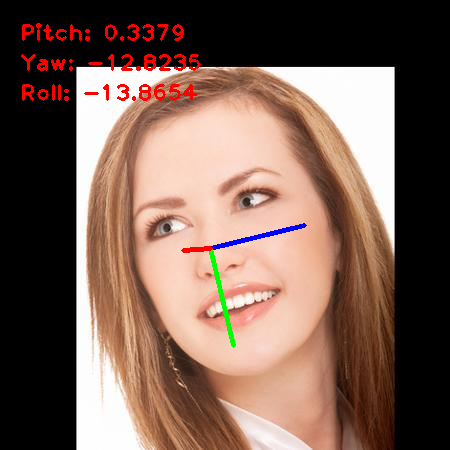

In [18]:
cv2_imshow(draw_axes(test_image, y_pred[0,0],y_pred[0,1], y_pred[0,2],tx = nose_coordinate[0],ty = nose_coordinate[1]))

# Testing on a video

In [21]:
from google.colab import files
uploaded2 = files.upload()

In [19]:
cap = cv2.VideoCapture("/content/Ultra realistic Deepfake of Elon Musk.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)

# Get the frame size (width, height) of the input video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_name = 'project_result.mp4'
video = cv2.VideoWriter(video_name, fourcc, fps, (frame_width, frame_height))

while (cap.isOpened()):

  ret, frame = cap.read()

  if not ret:
    break 

  x_frame,nose_coo = getting_main_points(frame)
  if len(nose_coo) == 2:
    nose_coordinate = nose_coo

  if x_frame.shape[1] == 936:
      y_pred = grid_search.predict(x_frame)
  
  result_img = draw_axes(frame, y_pred[0,0],y_pred[0,1], y_pred[0,2],tx = nose_coordinate[0],ty = nose_coordinate[1])
  video.write(result_img)

cv2.destroyAllWindows()
video.release()